In [16]:
# pip install git+https://github.com/d2cml-ai/csdid/
# pip install git+https://github.com/d2cml-ai/DRDID
# pip install joblib


# Agregate Analysis

In [66]:
from csdid.att_gt import ATTgt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [67]:
data_final = pd.read_csv("../output/quadkeys_final_df.csv")

In [68]:
data_final.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,index_righ,UBIGEO,CCDD,CCPP,...,quarter,DISTRITO,avg_d_mbps,DATE,Fecha_Entrada,first.treat,treat,first.treat_numeric,DATE_categorical,year_quarter_numeric
0,2100300121202033,39338,7386,18,478,56,1332,150140,15,1,...,1,SANTIAGO DE SURCO,39.338,2019Q1,2020Q4,2020Q4,1,8,2019Q1,1
1,2100300121202222,26534,6529,26,171,40,1332,150140,15,1,...,1,SANTIAGO DE SURCO,26.534,2019Q1,2020Q4,2020Q4,1,8,2019Q1,1
2,2100300120331133,23960,4519,16,225,32,1332,150140,15,1,...,1,SANTIAGO DE SURCO,23.960,2019Q1,2020Q4,2020Q4,1,8,2019Q1,1
3,2100300120313331,23637,4033,29,235,60,1332,150140,15,1,...,1,SANTIAGO DE SURCO,23.637,2019Q1,2020Q4,2020Q4,1,8,2019Q1,1
4,2100300121202231,34316,6107,17,255,42,1332,150140,15,1,...,1,SANTIAGO DE SURCO,34.316,2019Q1,2020Q4,2020Q4,1,8,2019Q1,1


In [7]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36912 entries, 0 to 36911
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   quadkey               36912 non-null  int64  
 1   avg_d_kbps            36912 non-null  int64  
 2   avg_u_kbps            36912 non-null  int64  
 3   avg_lat_ms            36912 non-null  int64  
 4   tests                 36912 non-null  int64  
 5   devices               36912 non-null  int64  
 6   index_righ            36912 non-null  int64  
 7   UBIGEO                36912 non-null  int64  
 8   CCDD                  36912 non-null  int64  
 9   CCPP                  36912 non-null  int64  
 10  CCDI                  36912 non-null  int64  
 11  DEPARTAMEN            36912 non-null  object 
 12  PROVINCIA             36912 non-null  object 
 13  OBJECTID              36912 non-null  float64
 14  ESRI_OID              36912 non-null  float64
 15  year               

## Average Trend Plot by groups

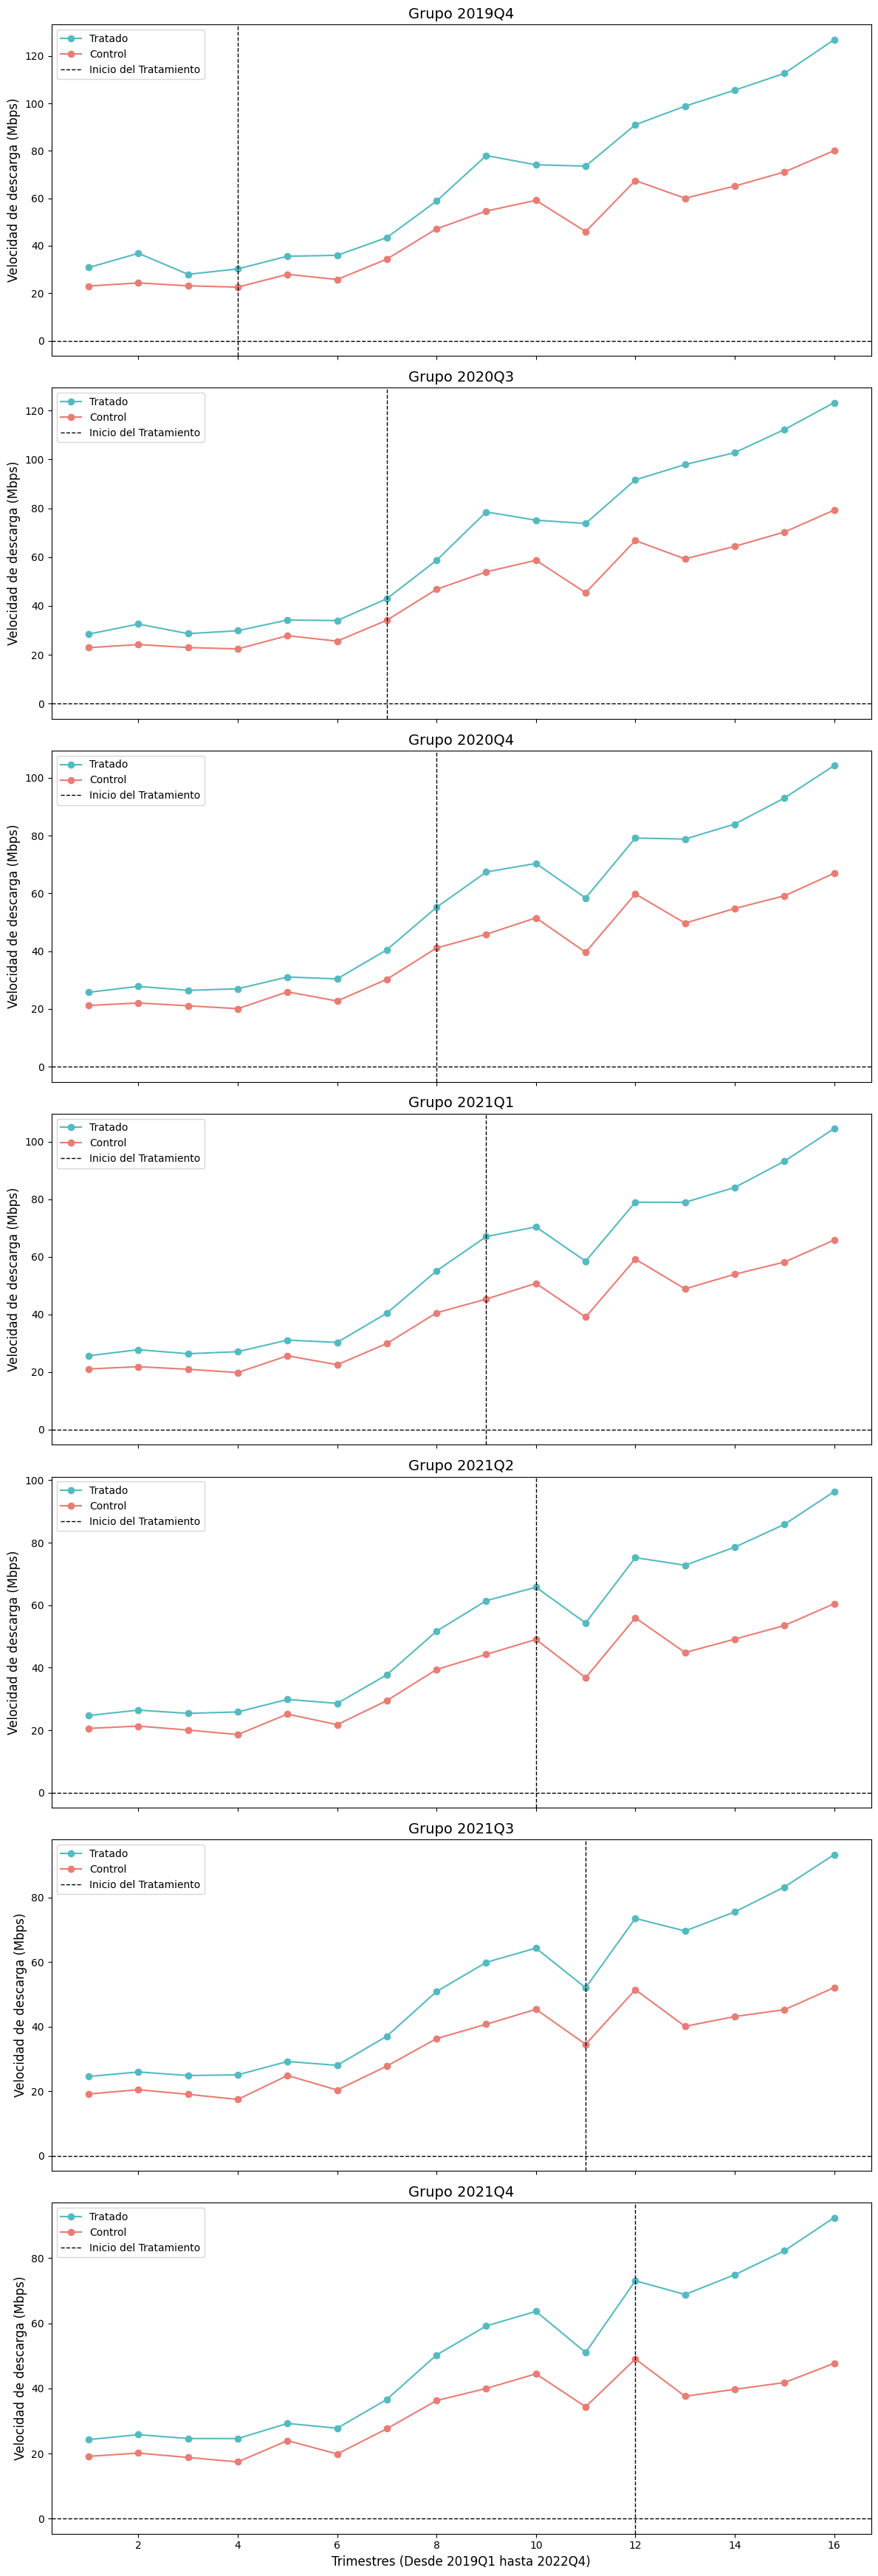

In [79]:
import matplotlib.pyplot as plt

# Paleta de colores personalizada
colors = {
    "Tratado": "#54bac1",  # Color para tratados
    "Control": "#e97c73"   # Color para controles
}

# Diccionario de títulos de grupos
group_titles = {
    4: "Grupo 2019Q4",
    7: "Grupo 2020Q3",
    8: "Grupo 2020Q4",
    9: "Grupo 2021Q1",
    10: "Grupo 2021Q2",
    11: "Grupo 2021Q3",
    12: "Grupo 2021Q4"
}

# Obtener los grupos únicos, excluyendo el grupo 0
groups = sorted(data_final['first.treat_numeric'].unique())
groups = [group for group in groups if group != 0]

# Crear gráficos para cada grupo
fig, axes = plt.subplots(len(groups), 1, figsize=(12, len(groups) * 5), sharex=True)

for i, group in enumerate(groups):
    # ** Tratados: Observaciones del grupo actual y anteriores, excluyendo el Grupo 0 **
    treated_data = data_final[
        (data_final['first.treat_numeric'] <= group) &  # Grupos tratados hasta el actual
        (data_final['first.treat_numeric'] != 0)       # Excluir el Grupo 0
    ]

    # ** Controles: Observaciones no tratadas aún o del grupo 0 **
    control_data = data_final[
        (data_final['first.treat_numeric'] > group) |  # Grupos que serán tratados después
        (data_final['first.treat_numeric'] == 0)      # Grupo 0 como control permanente
    ]

    # Graficar tratados si existen datos
    if not treated_data.empty:
        treated_trend = treated_data.groupby('year_quarter_numeric')['avg_d_mbps'].mean().reset_index()
        axes[i].plot(
            treated_trend['year_quarter_numeric'],
            treated_trend['avg_d_mbps'],
            label='Tratado',
            color=colors["Tratado"],
            marker='o'
        )

    # Graficar controles si existen datos
    if not control_data.empty:
        control_trend = control_data.groupby('year_quarter_numeric')['avg_d_mbps'].mean().reset_index()
        axes[i].plot(
            control_trend['year_quarter_numeric'],
            control_trend['avg_d_mbps'],
            label='Control',
            color=colors["Control"],
            marker='o'
        )

    # Añadir línea vertical para marcar el inicio del tratamiento
    axes[i].axvline(x=group, color='black', linestyle='--', linewidth=1, label='Inicio del Tratamiento')

    # Configurar el gráfico y añadir título del grupo
    title = group_titles.get(group, f'Tendencias Paralelas para Grupo {group}')
    axes[i].set_title(title, fontsize=14)
    axes[i].set_ylabel('Velocidad de descarga (Mbps)', fontsize=12)
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)  # Línea base
    axes[i].legend(fontsize=10)

# Configurar etiqueta del eje X para el último subplot
axes[-1].set_xlabel('Trimestres (Desde 2019Q1 hasta 2022Q4)', fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

In [70]:
attgt_estimation = ATTgt(yname = "avg_d_mbps",
              gname = "first.treat_numeric",
              idname = "quadkey",
              tname = "year_quarter_numeric",
              xformla = f"avg_d_mbps~1",
              data = data_final,
              panel = False,
              weights_name = "devices",

              ).fit(est_method = 'dr')
attgt_estimation.summ_attgt(n = 4).summary2

,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,4,2,5.0013,0,4.9179,-11.6708,21.6735,
1,4,3,-7.5171,0,4.3280,-22.1893,7.1551,
2,4,4,3.6446,1,1.5290,-1.5387,8.8280,
3,4,5,2.4517,1,2.2580,-5.2032,10.1066,
4,4,6,6.9473,1,2.4436,-1.3369,15.2315,
...,...,...,...,...,...,...,...,...
100,12,12,13.9504,1,6.4347,-7.8639,35.7646,
101,12,13,16.7183,1,3.5709,4.6126,28.8241,*
102,12,14,23.1910,1,3.6742,10.7351,35.6469,*
103,12,15,22.8539,1,4.2507,8.4435,37.2643,*


In [77]:
# Suponiendo que `attgt_estimation.summ_attgt(n=4)` ya ha sido ejecutado
summary_table = attgt_estimation.summ_attgt(n=4).summary2

# Convertir en un DataFrame
result_df = pd.DataFrame(summary_table)
result_df


,Group,Time,"ATT(g, t)",Post,Std. Error,[95% Pointwise,Conf. Band],
0,4,2,5.0013,0,4.9179,-11.6708,21.6735,
1,4,3,-7.5171,0,4.3280,-22.1893,7.1551,
2,4,4,3.6446,1,1.5290,-1.5387,8.8280,
3,4,5,2.4517,1,2.2580,-5.2032,10.1066,
4,4,6,6.9473,1,2.4436,-1.3369,15.2315,
...,...,...,...,...,...,...,...,...
100,12,12,13.9504,1,6.4347,-7.8639,35.7646,
101,12,13,16.7183,1,3.5709,4.6126,28.8241,*
102,12,14,23.1910,1,3.6742,10.7351,35.6469,*
103,12,15,22.8539,1,4.2507,8.4435,37.2643,*


## Table aggregate results

In [74]:
attgt_estimation.aggte(typec='calendar');



Overall summary of ATT's based on calendar time aggregation:
    ATT Std. Error  [95.0%  Conf. Int.]  
13.8014      0.721 12.3883      15.2144 *


Time Effects (calendar):
    Time  Estimate  Std. Error  [95.0% Simult.   Conf. Band   
0      4    3.6446      1.5622           0.5829      6.7064  *
1      5    2.4517      2.2203          -1.9000      6.8035   
2      6    6.9473      2.7805           1.4976     12.3970  *
3      7    4.1967      1.7990           0.6708      7.7226  *
4      8    6.4916      2.1761           2.2265     10.7566  *
5      9   14.3488      2.3379           9.7666     18.9311  *
6     10   10.0637      2.2145           5.7235     14.4040  *
7     11    6.8922      1.6380           3.6818     10.1026  *
8     12   13.0361      2.3498           8.4306     17.6416  *
9     13   21.0958      1.4383          18.2769     23.9147  *
10    14   25.0082      1.6320          21.8094     28.2069  *
11    15   30.4459      1.7353          27.0447     33.8471  *
12    1

## Coeff Plot Aggregate Result

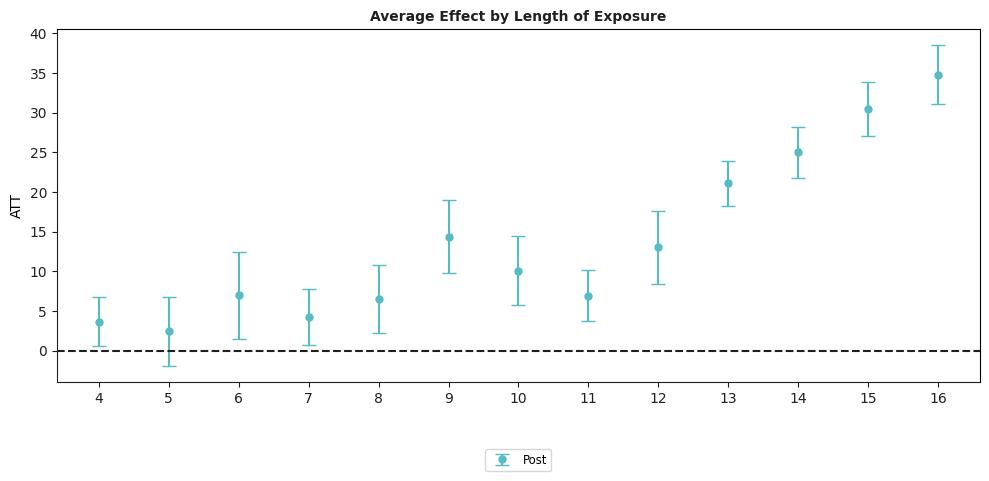

<Axes: title={'center': 'Average Effect by Length of Exposure'}, ylabel='ATT'>

In [75]:
attgt_estimation.plot_aggte()


## Plot by Treatment Group

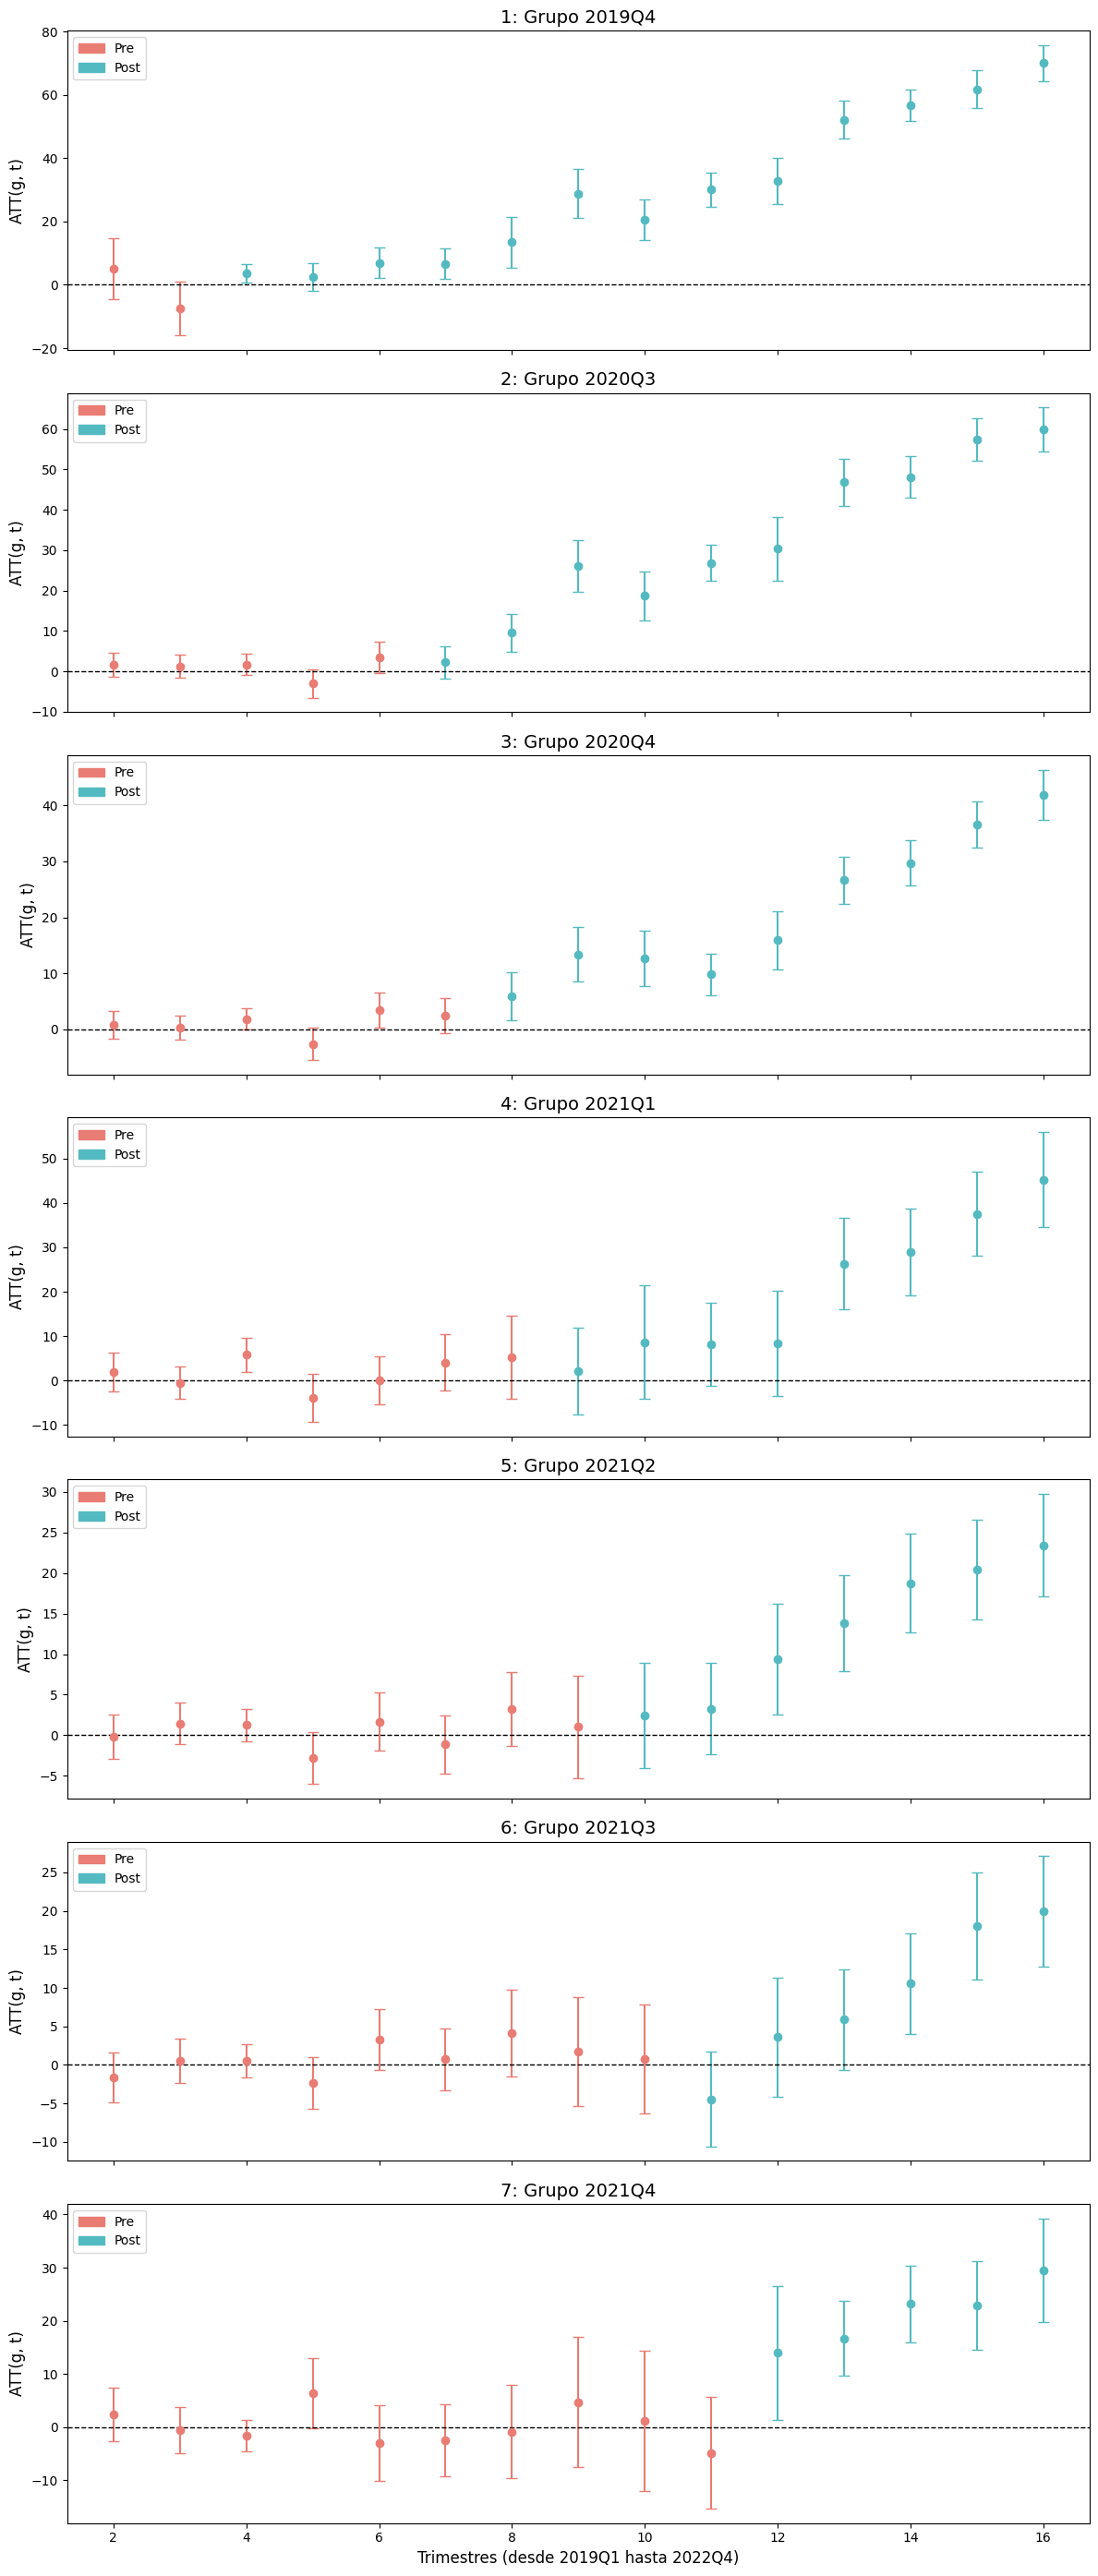

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Import the necessary module

# Paleta de colores personalizada
colors = {
    "Pre": "#e97c73",  # Color para Pre
    "Post": "#54bac1"  # Color para Post
}

# Diccionario para cambiar los títulos de los grupos
group_titles = {
    4: "Grupo 2019Q4",
    7: "Grupo 2020Q3",
    8: "Grupo 2020Q4",
    9: "Grupo 2021Q1",
    10: "Grupo 2021Q2",
    11: "Grupo 2021Q3",
    12: "Grupo 2021Q4"
}

# Crear la figura y subplots (aumentar tamaño y espacio entre subplots)
groups = result_df["Group"].unique()  # Asegúrate de que `result_df` está definido
fig, axes = plt.subplots(len(groups), 1, figsize=(12, len(groups) * 4), sharex=True)

for i, group in enumerate(groups):
    group_data = result_df[result_df["Group"] == group]

    # Graficar cada punto individualmente con su color
    for _, row in group_data.iterrows():
        # Determinar el color según si es Pre o Post
        point_color = colors["Post"] if row["Time"] >= group else colors["Pre"]
        axes[i].errorbar(
            row["Time"],
            row["ATT(g, t)"],
            yerr=1.96 * row["Std. Error"],
            fmt='o',
            ecolor=point_color,  # Color de las barras de error
            color=point_color,   # Color del marcador
            capsize=4            # Tamaño de los extremos de las barras de error
        )

    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)  # Línea base
    # Cambiar el título del grupo basado en el diccionario y agregar índice
    axes[i].set_title(f"{i + 1}: {group_titles.get(group, f'Group {group}')}", fontsize=14)
    axes[i].set_ylabel('ATT(g, t)', fontsize=12)

    # Añadir la leyenda personalizada
    pre_patch = mpatches.Patch(color=colors["Pre"], label="Pre")
    post_patch = mpatches.Patch(color=colors["Post"], label="Post")
    axes[i].legend(handles=[pre_patch, post_patch], loc='upper left', fontsize=10) # Changed ax to axes[i]

# Ajustes finales
axes[-1].set_xlabel('Trimestres (desde 2019Q1 hasta 2022Q4)', fontsize=12)
plt.tight_layout()
plt.show()


## Average Trend Plot by groups

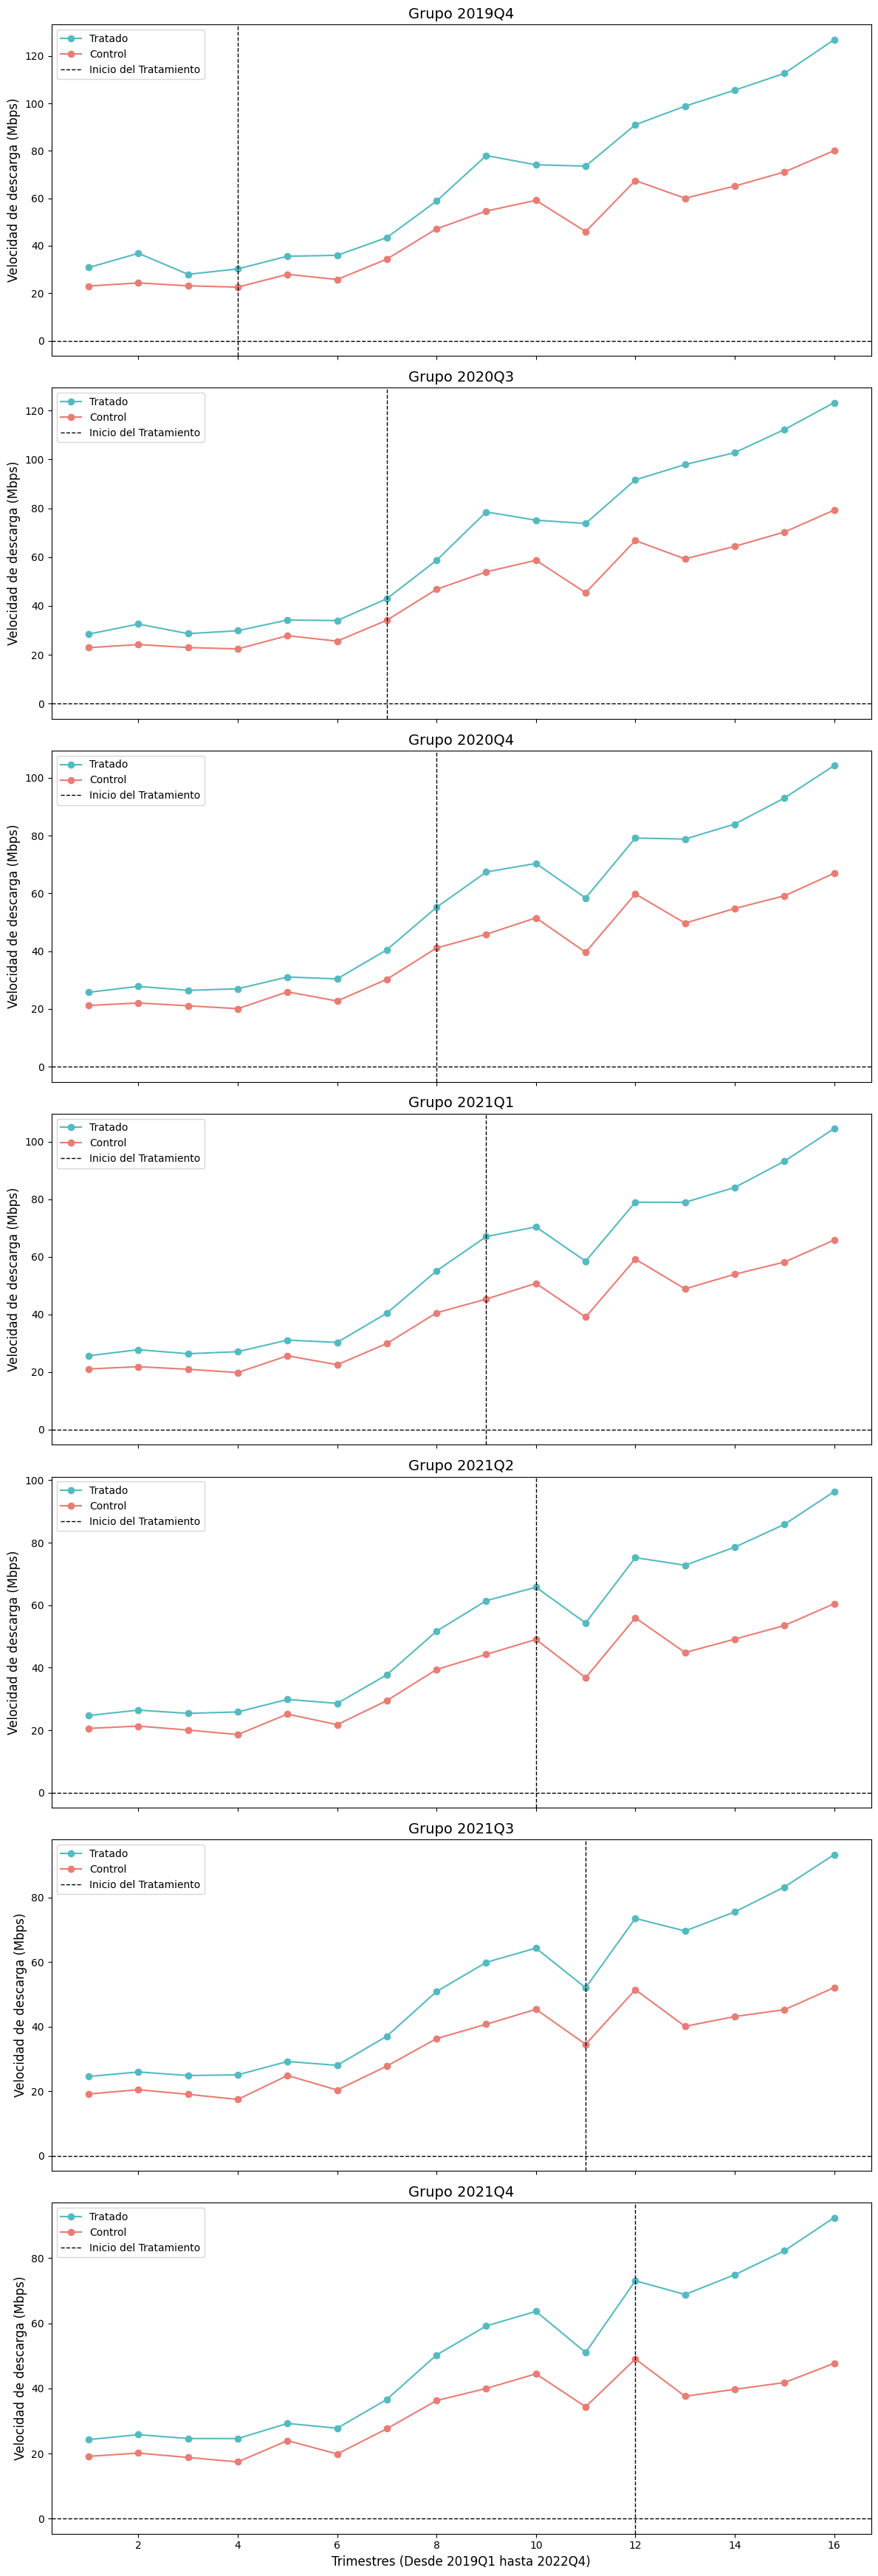

In [78]:
import matplotlib.pyplot as plt

# Paleta de colores personalizada
colors = {
    "Tratado": "#54bac1",  # Color para tratados
    "Control": "#e97c73"   # Color para controles
}

# Diccionario de títulos de grupos
group_titles = {
    4: "Grupo 2019Q4",
    7: "Grupo 2020Q3",
    8: "Grupo 2020Q4",
    9: "Grupo 2021Q1",
    10: "Grupo 2021Q2",
    11: "Grupo 2021Q3",
    12: "Grupo 2021Q4"
}

# Obtener los grupos únicos, excluyendo el grupo 0
groups = sorted(data_final['first.treat_numeric'].unique())
groups = [group for group in groups if group != 0]

# Crear gráficos para cada grupo
fig, axes = plt.subplots(len(groups), 1, figsize=(12, len(groups) * 5), sharex=True)

for i, group in enumerate(groups):
    # ** Tratados: Observaciones del grupo actual y anteriores, excluyendo el Grupo 0 **
    treated_data = data_final[
        (data_final['first.treat_numeric'] <= group) &  # Grupos tratados hasta el actual
        (data_final['first.treat_numeric'] != 0)       # Excluir el Grupo 0
    ]

    # ** Controles: Observaciones no tratadas aún o del grupo 0 **
    control_data = data_final[
        (data_final['first.treat_numeric'] > group) |  # Grupos que serán tratados después
        (data_final['first.treat_numeric'] == 0)      # Grupo 0 como control permanente
    ]

    # Graficar tratados si existen datos
    if not treated_data.empty:
        treated_trend = treated_data.groupby('year_quarter_numeric')['avg_d_mbps'].mean().reset_index()
        axes[i].plot(
            treated_trend['year_quarter_numeric'],
            treated_trend['avg_d_mbps'],
            label='Tratado',
            color=colors["Tratado"],
            marker='o'
        )

    # Graficar controles si existen datos
    if not control_data.empty:
        control_trend = control_data.groupby('year_quarter_numeric')['avg_d_mbps'].mean().reset_index()
        axes[i].plot(
            control_trend['year_quarter_numeric'],
            control_trend['avg_d_mbps'],
            label='Control',
            color=colors["Control"],
            marker='o'
        )

    # Añadir línea vertical para marcar el inicio del tratamiento
    axes[i].axvline(x=group, color='black', linestyle='--', linewidth=1, label='Inicio del Tratamiento')

    # Configurar el gráfico y añadir título del grupo
    title = group_titles.get(group, f'Tendencias Paralelas para Grupo {group}')
    axes[i].set_title(title, fontsize=14)
    axes[i].set_ylabel('Velocidad de descarga (Mbps)', fontsize=12)
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)  # Línea base
    axes[i].legend(fontsize=10)

# Configurar etiqueta del eje X para el último subplot
axes[-1].set_xlabel('Trimestres (Desde 2019Q1 hasta 2022Q4)', fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

In [13]:
treated_counties = data_final[data_final['treat'] == 1]['quadkey'].nunique()
print(treated_counties)

2229


In [14]:
# Contar cuántos tratados hay
treated_counties = data_final[data_final['treat'] == 1]['quadkey'].nunique()

# Contar cuántos no tratados hay
untreated_counties = data_final[data_final['treat'] == 0]['quadkey'].nunique()

# Imprimir los resultados
print(f"Cantidad de tratados: {treated_counties}")
print(f"Cantidad de no tratados: {untreated_counties}")


Cantidad de tratados: 2229
Cantidad de no tratados: 1175


In [15]:
# Calcular el total de distritos
total_counties = data_final['quadkey'].nunique()

# Contar cuántos tratados hay
treated_counties = data_final[data_final['treat'] == 1]['quadkey'].nunique()

# Contar cuántos no tratados hay
untreated_counties = data_final[data_final['treat'] == 0]['quadkey'].nunique()

# Calcular los porcentajes
treated_percentage = (treated_counties / total_counties) * 100
untreated_percentage = (untreated_counties / total_counties) * 100

# Imprimir los resultados
print(f"Porcentaje de tratados: {treated_percentage:.2f}%")
print(f"Porcentaje de no tratados: {untreated_percentage:.2f}%")


Porcentaje de tratados: 65.48%
Porcentaje de no tratados: 34.52%
